# Experiments with binary classification diagnosis

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt

In [69]:
from itertools import cycle

from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.preprocessing import MinMaxScaler

from scipy import interp

In [3]:
from numpy import random

## Simulate y_true and y_pred

In [4]:
label_0_size = 20000
label_1_size = 80000

In [5]:
y_pred_0 = random.normal(loc=0, size=label_0_size)
y_pred_1 = random.normal(loc=1, size=label_1_size)

y_pred_0 = np.clip(y_pred_0, 0, 1)
y_pred_1 = np.clip(y_pred_1, 0, 1)

y_pred = np.concatenate((y_pred_0, y_pred_1))

In [6]:
y_true = np.concatenate((np.array([0] * label_0_size), np.array([1] * label_1_size)))

In [7]:
date_index = list(range(label_0_size + label_1_size))
random.shuffle(date_index)

---

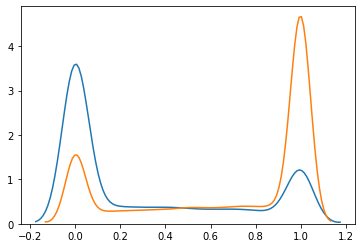

In [8]:
ax = sns.kdeplot(y_pred_0)
ax = sns.kdeplot(y_pred_1, ax=ax)

## AUC

In [18]:
len(np.unique(y_true))

2

In [95]:
def compute_roc(y_pred, y_true):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(np.unique(y_true))-1
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    return roc_auc, fpr, tpr

def plot_roc_all(y_pred, y_true):
    if y_true.ndim == 1:
        roc_auc, fpr, tpr = compute_roc(y_pred.reshape(-1, 1), y_true.reshape(-1, 1))
    else:
        roc_auc, fpr, tpr = compute_roc(y_pred, y_true)
        
    n_classes = len(np.unique(y_true))-1
    
    # Compute macro-average ROC curve and ROC area
    lw = 2
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

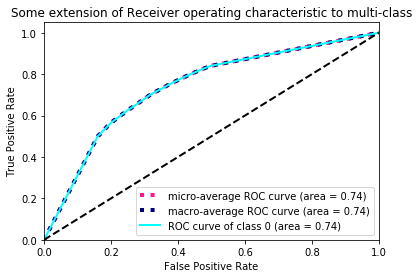

In [71]:
plot_roc_all(y_pred, y_true)

## F1 por threshold

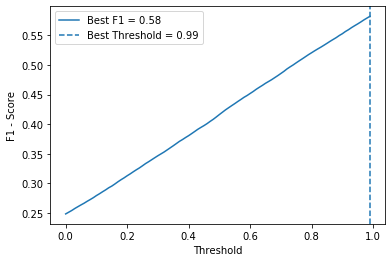

In [107]:
thresholds = np.arange(0, 1, 0.01)
f1_list = []

max_th = 0
max_f1 = 0

for th in thresholds:
    y_pred_label = (y_pred <= th).astype(int)
    f1_th = f1_score(y_true, y_pred_label)
    f1_list.append(f1_th)
    
    if f1_th > max_f1:
        max_f1 = f1_th
        max_th = th
    
fig, ax = plt.subplots()
ax.plot(thresholds, f1_list, label=f"Best F1 = {max_f1:0.2f}")
ax.axvline(max_th, linestyle='--', label=f"Best Threshold = {max_th:0.2f}")
ax.set_xlabel("Threshold")
ax.set_ylabel("F1 - Score")
ax.legend()

plt.show()

## Matrix de confusao

## Acuracia ao longo do tempo